# Analyzing JNJ gradient descent

In this notebook, we'll analyze the gradient descent method of [1711.10456](https://arxiv.org/abs/1711.10456).

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The two-dimensional Rastrigin function is

$f(x,y) = 20 +x^2+y^2-10(\cos(2\pi x) + \cos(2\pi y)).$

In [65]:
def rastrigin(pt: np.ndarray):
    """Rastrigin function with A=10."""
    x, y = pt
    return 20 + x**2 + y**2 - 10 * (np.cos(2*np.pi*x) + np.cos(2*np.pi* y))

def rastrigin_grad(pt: np.ndarray) -> np.ndarray:
    """Gradient of Rastrigin function."""
    grad = 2 * pt + 20 * np.pi * np.sin(2*np.pi*pt)
    return grad

In [50]:
rastrigin(np.array([0.1,1.1]))

5.039660112501057

In [91]:
def plot_rastrigin(x_range, y_range):
    X = np.linspace(*x_range)
    Y = np.linspace(*y_range)

    X, Y = np.meshgrid(X,Y)
    Z = rastrigin(np.array([X, Y]))
    conplot = plt.contour(X, Y, Z)
    conplot.ax.set_aspect('equal')
    return conplot

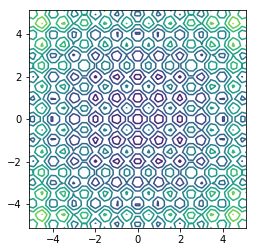

In [92]:
plot_rastrigin((-5.12, 5.12), (-5.12, 5.12))

Here's a 3d plot:
<img src="rastrigin_function.png" width=600 />

In [190]:
def sgd(fun, gradfun, start, eps, n, momentum=0) -> np.ndarray:
    """Stochastic gradient descent.
    
    Args:
    fun: function to minimize
    gradfun: gradient of fun
    start: starting point
    eps: learning rate
    n: iterations

    Returns:
    minpath: gradient descent path
    """
    dim = len(start)
    minpath = np.zeros((n,dim))
    minpath[0] = start
    delta = np.zeros(dim)
    for i in range(1,n):
        delta = momentum * delta - eps * gradfun(minpath[i-1])
        minpath[i] = minpath[i-1] + delta
    return minpath

In [41]:
testtpt = np.array([0,1])
(1,*(testtpt.shape))

(1, 2)

In [53]:
rastrigin_grad(np.array([0.1, 0.2]))

array([37.13163661, 60.15664329])

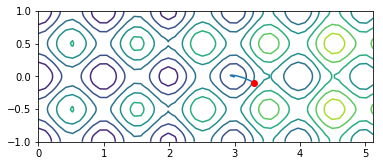

In [195]:
startpt = np.array([3.3,-0.1])
stoch_path = sgd(rastrigin, rastrigin_grad, startpt, 1e-3, n=10000, momentum=0.5)
plot_rastrigin((0, 5.12), (-1,1))
plt.plot(stoch_path[:,0], stoch_path[:,1])
plt.plot(startpt[0], startpt[1],'or')

Implement the algorithm:

In [160]:
def exploit_neg_curv(fun, point, speed, s):
    """Helper function that's used when curvature becomes negative."""
    if np.linalg.norm(speed) >= s:
        pass
    else:
        if np.linalg.norm(speed) == 0:
            delta = np.zeros(point.shape)
        else:
            delta = s * speed / np.linalg.norm(speed)
        if fun(point + delta) > fun(point-delta):
            point = point-delta
        else:
            point = point + delta
    return (point, np.zeros(point.shape))

def ball_uni(dim, radius):
    """Generate uniformly random point inside ball with radius 'radius'."""
    
    #Generate random point on n-sphere
    rand_sphere = np.random.normal(size=dim)
    rand_sphere /= np.linalg.norm(rand_sphere)
    
    #Generate properly distributed radius
    rand_r = np.random.random()**(1/dim)

    #Multiply them to get random points in the ball
    return radius * (rand_sphere * rand_r)


def jnj(fun, gradfun, start, eps, eta, theta, gamma, s, r, J, n) -> np.ndarray:
    """JNJ gradient descent.
    
    Args:
    fun: function to minimize
    gradfun: gradient of fun
    start: starting point
    eps, eta, theta, gamma, s, r, J: see paper
    n: iterations

    Returns:
    minpath: path of values of x_t
    speedpath: path of values of v_t
    """
    dim = len(start)
    minpath = np.zeros((n,dim))
    speedpath = np.zeros((n,dim))
    minpath[0] = start
    #perfree counts how many iterations passed since the last perturbation
    perfree = 0
    #The next lines directly follow the paper:
    for i in range(n-1):
        gradvec = gradfun(minpath[i])
        if np.linalg.norm(gradvec) <= eps and perfree > J:
            minpath[i] += ball_uni(dim, r)
            perfree = 0
        y = minpath[i] + (1-theta) * speedpath[i]
        grady = gradfun(y)
        minpath[i+1] = y - eta * grady
        speedpath[i+1] = minpath[i+1] - minpath[i]
        #Note: Check that v!=0 prevents div. by zero in exploit_neg_curv
        if fun(minpath[i]) <=\
                (fun(y) + grady @ (minpath[i] - y) - gamma/2 * np.linalg.norm(minpath[i]-y)**2) and\
                    np.linalg.norm(speedpath[i])>0:
            #Negative curvature region detected!
            minpath[i+1], speedpath[i+1] = exploit_neg_curv(fun, minpath[i], speedpath[i], s)
        perfree += 1
    return minpath, speedpath

In [245]:
startpt = np.array([-3.3,-0.1])
jnj(rastrigin, rastrigin_grad, startpt, eps=1e-4, eta=1e-5, theta = 0.5, gamma=0.8, s=1.1, r=0.2, J=10, n=1000)

[-66.35664329 -37.13163661]


(array([[-3.30000000e+00, -1.00000000e-01],
        [-3.29933643e+00, -9.96286836e-02],
        [-2.33940667e+00,  4.37525719e-01],
        ...,
        [-1.01105892e-04, -5.37108798e-06],
        [-1.00300300e-04, -5.32829217e-06],
        [-9.95011259e-05, -5.28583734e-06]]),
 array([[0.00000000e+00, 0.00000000e+00],
        [6.63566433e-04, 3.71316366e-04],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [8.12062896e-07, 4.31395388e-08],
        [8.05592534e-07, 4.27958111e-08],
        [7.99173726e-07, 4.24548222e-08]]))

[66.35664329 37.13163661]


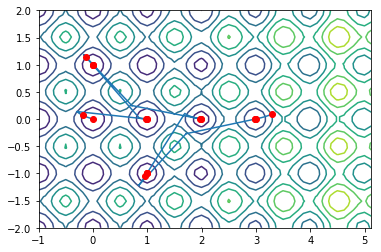

In [283]:
startpt = np.array([3.3,0.1])
niter = 1000
jnj_path, jnj_speeds =\
    jnj(rastrigin, rastrigin_grad, startpt, eps=1e-5, eta=1e-4, theta = 0.5, gamma=1, s=1.3, r=0.02, J=10, n=niter)
plot_rastrigin((-1, 5.12), (-2,2))
plt.plot(jnj_path[:,0], jnj_path[:,1])
for i in range(0,niter,50):
    plt.plot(jnj_path[i][0], jnj_path[i][1],'or')

In [175]:
def adam(grad, start, n=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=start
    param_traj=np.zeros([n+1,2])
    param_traj[0,]=start
    v=0;
    grad_sq=0;
    for j in range(n):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

In [179]:
startpt = np.array([3.3,-0.1])
adam(rastrigin_grad, startpt, n=1000, noise_strength=0)

array([[ 3.3       , -0.1       ],
       [ 3.2999    , -0.0999    ],
       [ 3.29976531, -0.09976532],
       ...,
       [ 3.19199476, -0.00889209],
       [ 3.19189634, -0.00883636],
       [ 3.19179793, -0.00878077]])

In [185]:
def ball_sha(shape, radius):
    """Generate uniformly random point inside ball with radius 'radius'."""
    dim = np.prod(shape)
    rand_sphere = np.random.normal(size=dim)
    rand_sphere /= np.linalg.norm(rand_sphere)
    rand_r = np.random.random() ** (1 / dim)

    return (radius * (rand_sphere * rand_r)).reshape(shape)

## McCormick function
<img src = "mccormick.jpg" width=500px />

$$f(x,y) = \sin(x+y) + (x-y)^2 -1.5x +2.5y +1$$

Minimum at $(-0.54719, -1.54719)$

In [250]:
def mccormick(pt):
    x, y = pt
    return np.sin(x+y) + (x-y)**2 - 1.5*x + 2.5*y + 1

def mccormick_grad(pt):
    x, y = pt
    grad_x = np.cos(x+y) + 2*(x-y) - 1.5
    grad_y = np.cos(x+y) - 2*(x-y) + 2.5
    return np.array([grad_x, grad_y])

In [263]:
startpt = np.array([-3.3,-0.1])
jnj(mccormick, mccormick_grad, startpt, eps=1e-4, eta=1e-3, theta = 0.5, gamma=0.8, s=0.5, r=0.02, J=10, n=2000)

[-8.86679819  7.93320181]


(array([[-3.3       , -0.1       ],
        [-3.2911332 , -0.1079332 ],
        [-3.27788305, -0.11978225],
        ...,
        [-0.54853189, -1.54853146],
        [-0.54852726, -1.54852684],
        [-0.54852265, -1.54852223]]),
 array([[ 0.00000000e+00,  0.00000000e+00],
        [ 8.86679819e-03, -7.93320181e-03],
        [ 1.32501542e-02, -1.18490458e-02],
        ...,
        [ 4.64385694e-06,  4.64038614e-06],
        [ 4.62775913e-06,  4.62431621e-06],
        [ 4.61171707e-06,  4.60830180e-06]]))

In [258]:
startpt = np.array([3.3,-0.1])
adam(mccormick_grad, startpt, n=10000, noise_strength=0)

array([[ 3.3       , -0.1       ],
       [ 3.2999    , -0.0999    ],
       [ 3.29976531, -0.09976531],
       ...,
       [ 2.3141822 ,  0.89590574],
       [ 2.31409168,  0.89600322],
       [ 2.31400117,  0.8961007 ]])